In [51]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os



df_min= pd.read_csv('C:/Users/MyPC/Desktop/Projet Gps/AutreP/Livraison 1_CSV/corrected_gps_information_new.csv')

df_min=df_min.loc[df_min['sampno']==8447624,:]
%matplotlib inline

print ('Total GPS points: ' + str(df_min.shape[0]))

import gmplot
# declare the center of the map, and how much we want the map zoomed in
gmap = gmplot.GoogleMapPlotter(df_min.latitude[0], df_min.longitude[0], 11)
gmap.plot(df_min.latitude, df_min.longitude)
gmap.draw("Utilisateur1Trajerctoire.html")
print(df_min.head())
df_min['time']=0
for i in range(0,len(df_min)):
    df_min.loc[i,'time']=(df_min.loc[i,'time_local']).split(" ")[1]
print(df_min.head())

Total GPS points: 2929
   Unnamed: 0   sampno  placeno             time_utc           time_local  \
0           1  8447624        3  2014-09-16 05:33:01  2014-09-16 07:33:01   
1           2  8447624        3  2014-09-16 05:33:06  2014-09-16 07:33:06   
2           3  8447624        3  2014-09-16 05:33:11  2014-09-16 07:33:11   
3           4  8447624        3  2014-09-16 05:33:16  2014-09-16 07:33:16   
4           5  8447624        3  2014-09-16 05:33:21  2014-09-16 07:33:21   

   longitude   latitude    altitude  speed valid  hdop  nbsat  
0   2.284952  48.963909  284.100006    2.5     A   1.0      7  
1   2.285028  48.963881  282.500000    5.6     A   1.0      7  
2   2.285242  48.963832  282.399994    9.5     A   0.9      8  
3   2.285622  48.963788  281.500000   12.9     A   1.4      7  
4   2.286126  48.963615  282.500000   18.1     A   1.4      7  
   Unnamed: 0   sampno  placeno             time_utc           time_local  \
0           1  8447624        3  2014-09-16 05:33:01 

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# represent GPS points as (lat, lon)
coords = df_min.as_matrix(columns=['latitude', 'longitude'])
#coords1= df_min.as_matrix(columns=['lat', 'lng', 'alt', 'date','time'])

# earth's radius in km
kms_per_radian = 6371.0088
# define epsilon as 0.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian

# eps is the max distance that points can be from each other to be considered in a cluster
# min_samples is the minimum cluster size (everything else is classified as noise)
db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
# get the number of clusters (ignore noisy samples which are given the label -1)
num_clusters = len(set(cluster_labels) - set([-1]))

print ('Clustered ' + str(len(df_min)) + ' points to ' + str(num_clusters) + ' clusters')

# turn the clusters in to a pandas series
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print(clusters.head())

Clustered 2929 points to 4 clusters
0    [[48.963909, 2.284952], [48.963881, 2.285028],...
1    [[48.959188, 2.298509], [48.958664, 2.299503],...
2    [[48.942551, 2.303164], [48.941362, 2.303753],...
3    [[48.920385, 2.314174], [48.919797, 2.314415],...
dtype: object


In [4]:
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

# get the centroid point for each cluster
centermost_points = clusters.map(get_centermost_point)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'longitude':lons, 'latitude':lats})

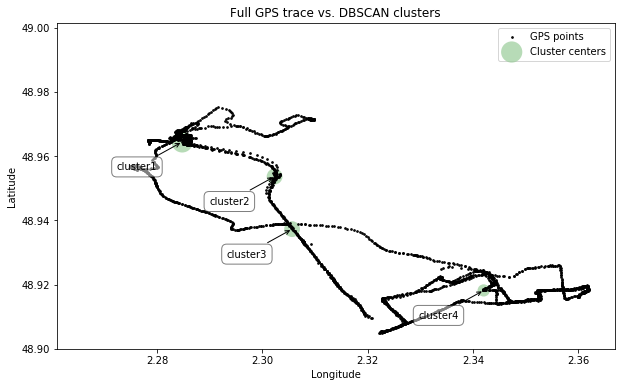

In [5]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['longitude'][0], rep_points['latitude'][0], c='#99cc99', edgecolor='None', alpha=0.7, s=450)
ax.scatter(rep_points['longitude'][1], rep_points['latitude'][1], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['longitude'][2], rep_points['latitude'][2], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['longitude'][3], rep_points['latitude'][3], c='#99cc99', edgecolor='None', alpha=0.7, s=150)
df_scatter = ax.scatter(df_min['longitude'], df_min['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full GPS trace vs. DBSCAN clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['GPS points', 'Cluster centers'], loc='upper right')

labels = ['cluster{0}'.format(i) for i in range(1, num_clusters+1)]
for label, x, y in zip(labels, rep_points['longitude'], rep_points['latitude']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-25, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [6]:
centermost_points

0    (48.964419, 2.284805)
1    (48.953648, 2.302346)
2    (48.937265, 2.305665)
3     (48.91818, 2.342036)
dtype: object

In [66]:
rep_points

,lat,lon
0,39.999484,116.318399
1,39.994188,116.199206
2,40.001322,116.171410
3,39.990646,116.188471
4,40.032206,116.312929
5,40.073016,116.338559
6,39.976682,116.383428
7,39.952184,116.329903
8,39.966130,116.360070
9,39.908577,116.409670


In [19]:
print(set(M[0]))
from itertools import groupby
[len(list(group)) for key, group in groupby(M[0])]
 
for
    

{'07', '20', '18', '16', '22', '23', '08', '19', '13', '17'}


[14, 52, 34, 26, 14, 92, 54, 50, 40, 87, 9, 46, 14, 66, 59, 100, 34, 48, 58]

In [9]:
# Get the hours for each cluster
M = []
def myfunc(row):
    t = df_min[(df_min['latitude']==row[0]) & (df_min['longitude']==row[1])]['time'].iloc[0]
    return t[:t.index(':')]
for i in range(num_clusters):
    hours = np.apply_along_axis(myfunc, 1, clusters[i]).tolist()
    M.append(hours)

(array([  39.,    0.,  491.,    0.,    0.,   13.,    0.,  237.,    0.,  598.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

D:\Programmes\Anaconda2\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


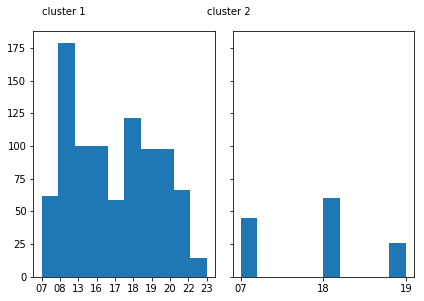

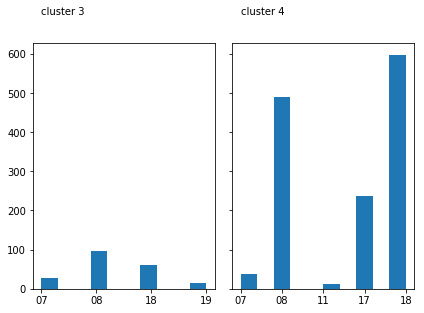

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter



fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].text(0, 200, "cluster 1")

axs[0].hist(M[0] )
axs[0].text(23, 200, "cluster 2")

axs[1].hist(M[1] )

fig1, axs1 = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs1[0].text(0, 700, "cluster 3")
axs1[0].hist(M[2] )
axs1[1].text(0, 700, "cluster 4")
axs1[1].hist(M[3] )



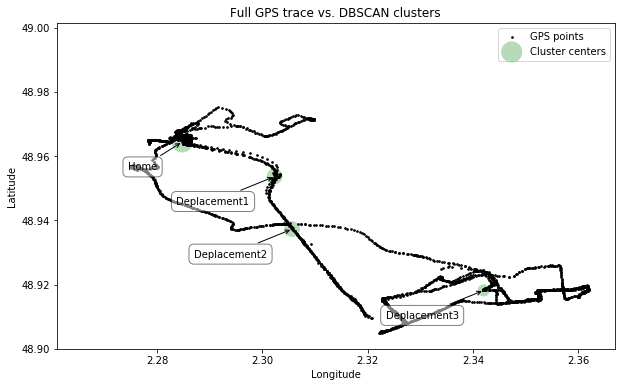

In [49]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['longitude'][0], rep_points['latitude'][0], c='#99cc99', edgecolor='None', alpha=0.7, s=450)
ax.scatter(rep_points['longitude'][1], rep_points['latitude'][1], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['longitude'][2], rep_points['latitude'][2], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['longitude'][3], rep_points['latitude'][3], c='#99cc99', edgecolor='None', alpha=0.7, s=150)
df_scatter = ax.scatter(df_min['longitude'], df_min['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full GPS trace vs. DBSCAN clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['GPS points', 'Cluster centers'], loc='upper right')

labels = ['Home', 'Deplacement1', 'Deplacement2', 'Deplacement3']
for label, x, y in zip(labels, rep_points['longitude'][:num_clusters], rep_points['latitude'][:num_clusters]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-25, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [50]:
gmap = gmplot.GoogleMapPlotter(rep_points['latitude'][0], rep_points['longitude'][0], 11)
gmap.plot(df_min.latitude, df_min.longitude)
gmap.heatmap(rep_points['latitude'][:4], rep_points['longitude'][:4], radius=20)
gmap.draw("1erUtilisateurCluster.html")

0    [[39.996342, 116.29777800000001, 179, 2008-10-...
dtype: object
